In [121]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.applications import ResNet50, VGG19, VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM, SVC
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
import seaborn as sns

In [122]:
# Loading the data

X_labeled = np.load("Xtrain1.npy")
X_unlabeled = np.load("Xtrain1_extra.npy")
Y_train_labeled = np.load("Ytrain1.npy")
X_test = np.load("Xtest1.npy")

(2783, 2304)
(904, 2304)


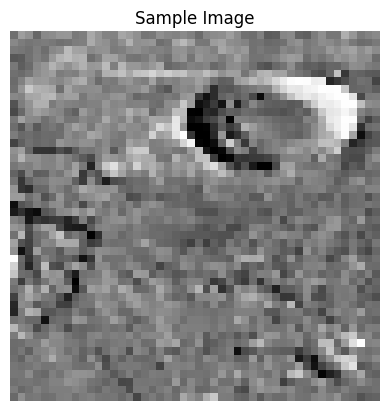

In [123]:
# Check the shape of the data

print(X_labeled.shape)
print(X_unlabeled.shape)

#Normalization

X_labeled = X_labeled/255
X_unlabeled = X_unlabeled/255
X_test = X_test/255

#Turn the data 2D

resized = np.resize(X_labeled[1], [48,48])
plt.imshow(resized, cmap='gray')
plt.title("Sample Image")
plt.axis('off')
plt.show()

In [124]:
# Data Imbalance

crater_images = sum(Y_train_labeled)
no_crater_images = len(Y_train_labeled) - crater_images
ratio_no_crater_crater = no_crater_images/crater_images
print("Number of crater images: ", crater_images)
print("Number of no crater images: ", no_crater_images)
print("Ratio no crater/crater: ", ratio_no_crater_crater)

#Class Weights

class_weights_first = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train_labeled), y=Y_train_labeled.flatten())
class_weight_dict_first = dict(enumerate(class_weights_first))
print("Class weights: ", class_weight_dict_first)

Number of crater images:  1777
Number of no crater images:  1006
Ratio no crater/crater:  0.566122678671919
Class weights:  {0: 1.3832007952286283, 1: 0.7830613393359594}


In [125]:
# Reshaping and Data Splitting

X_train_reshaped = X_labeled.reshape(len(X_labeled), 48, 48, 1)
X_unlabeled_train = X_unlabeled.reshape(len(X_unlabeled), 48, 48, 1)
X_test_reshaped = X_test.reshape(len(X_test), 48, 48, 1)

X_train, X_val, Y_train, Y_val = train_test_split(X_train_reshaped, Y_train_labeled, test_size=0.2, random_state=42)

Methods for Data Imbalance: Data Augmentation only on Minority Class

Data augmentation is a technique that can be used to improve the robustness and accuracy of a machine learning model by creating additional examples from the original dataset.

https://www.picsellia.com/post/improve-imbalanced-datasets-in-computer-vision


In [126]:
majority_indices = np.where(Y_train == 1)[0]
minority_indices = np.where(Y_train == 0)[0]

X_train_majority = X_train[majority_indices]
X_train_minority = X_train[minority_indices]

target_minority_samples = len(X_train_majority)
num_augmented_samples = target_minority_samples - len(X_train_minority)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_minority_images = []
for i in range(num_augmented_samples):
    img = X_train_minority[i % len(X_train_minority)].reshape((1, 48, 48, 1))
    augmented_img = next(datagen.flow(img, batch_size=1))[0]
    augmented_minority_images.append(augmented_img)

X_train_minority_balanced = np.concatenate([X_train_minority, np.array(augmented_minority_images)])
Y_train_minority_balanced = np.zeros(len(X_train_minority_balanced))

X_train_balanced_DA = np.concatenate([X_train_majority, X_train_minority_balanced])
Y_train_balanced_DA = np.concatenate([np.ones(len(X_train_majority)), Y_train_minority_balanced])

indices = np.arange(len(Y_train_balanced_DA))
np.random.shuffle(indices)
X_train_balanced_DA, Y_train_balanced_DA = X_train_balanced_DA[indices], Y_train_balanced_DA[indices]

print("Balanced training set shape:", X_train_balanced_DA.shape)
print("Balanced class distribution:", np.bincount(Y_train_balanced_DA.astype(int)))

Balanced training set shape: (2814, 48, 48, 1)
Balanced class distribution: [1407 1407]


Methods for Data Imbalance: Random Sampling

https://medium.com/@shubhamgupta.3101994/addressing-data-imbalance-in-image-classification-techniques-and-strategies-b922fb3c5124
https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

There are two main approaches to random resampling for imbalanced classification; they are oversampling and undersampling.

 - Random Oversampling: Randomly duplicate examples in the minority class.
 - Random Undersampling: Randomly delete examples in the majority class.

Random resampling provides a naive technique for rebalancing the class distribution for an imbalanced dataset.
Random oversampling duplicates examples from the minority class in the training dataset and can result in overfitting for some models.

Random undersampling deletes examples from the majority class and can result in losing information invaluable to a model.

Random Over Sampling (ROS)

In [127]:
X_train_flattened = X_train_balanced_DA.reshape(len(X_train_balanced_DA), -1)
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_ROS, Y_train_ROS = ros.fit_resample(X_train_flattened, Y_train_balanced_DA)
X_train_ROS = X_train_ROS.reshape(-1, 48, 48, 1)
unique, counts = np.unique(Y_train_ROS, return_counts=True)
print("Balanced class distribution:", dict(zip(unique, counts)))

print(X_train_ROS.shape)
print(Y_train_ROS.shape)

Balanced class distribution: {0.0: 1407, 1.0: 1407}
(2814, 48, 48, 1)
(2814,)


Random Under Sampling (RUS)

In [128]:
X_train_flattened = X_train.reshape(len(X_train), -1)

rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

X_train_RUS, Y_train_RUS = rus.fit_resample(X_train_flattened, Y_train)
X_train_RUS = X_train_RUS.reshape(-1, 48, 48, 1)

unique, counts = np.unique(Y_train_RUS, return_counts=True)

print("Balanced class distribution:", dict(zip(unique, counts)))

Balanced class distribution: {0: 819, 1: 819}


Combination of ROS and RUS

In [129]:
X_train_flattened = X_train.reshape(len(X_train), -1)

ros = RandomOverSampler(sampling_strategy=0.95, random_state=42)

X_train_over, Y_train_over = ros.fit_resample(X_train_flattened, Y_train)

rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)

X_train_both, Y_train_both = rus.fit_resample(X_train_over, Y_train_over)

X_train_both = X_train_both.reshape(-1, 48, 48, 1)

unique, counts = np.unique(Y_train_over, return_counts=True)

print("Final balanced class distribution:", dict(zip(unique, counts)))

Final balanced class distribution: {0: 1336, 1: 1407}


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_147 (Conv2D)             │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_147               │ (None, 23, 23, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_148 (Conv2D)             │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_148               │ (None, 10, 10, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_149 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_149               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_56 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 363,265 (1.39 MB)

 Trainable params: 363,265 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5334 - loss: 0.6899 - val_accuracy: 0.8187 - val_loss: 0.5232
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7759 - loss: 0.5611 - val_accuracy: 0.8366 - val_loss: 0.3924
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8380 - loss: 0.3896 - val_accuracy: 0.8743 - val_loss: 0.3342
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8708 - loss: 0.3144 - val_accuracy: 0.8797 - val_loss: 0.3263
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8957 - loss: 0.2612 - val_accuracy: 0.8725 - val_loss: 0.3276
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8991 - loss: 0.2555 - val_accuracy: 0.8528 - val_loss: 0.3767
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9243 - loss: 0.2067 - val_accuracy: 0.8779 - val_loss: 0.3214
Epoch 8/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9304 - loss: 0.1871 - val_accuracy: 0.

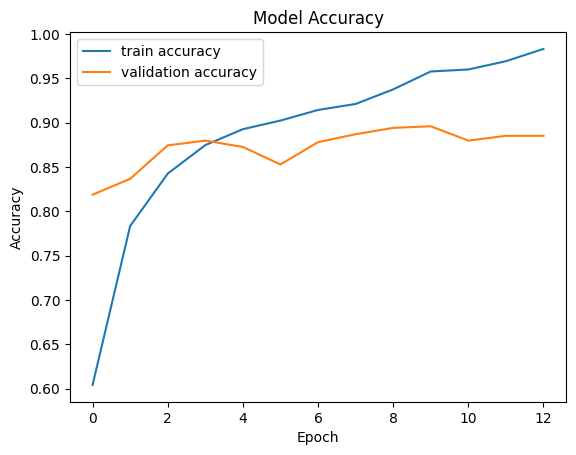

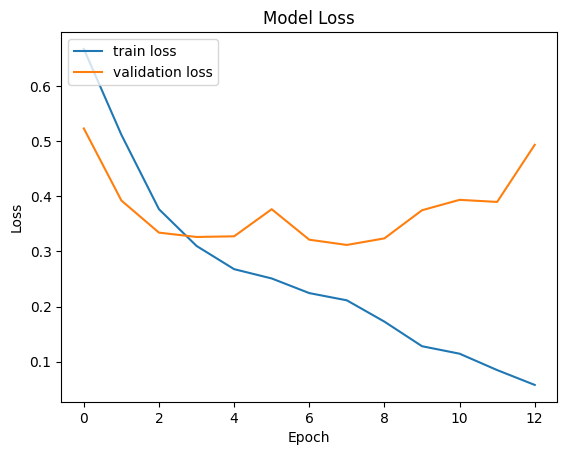

In [130]:
from sklearn.utils.class_weight import compute_class_weight
# Build CNN model
def create_model():
    model = Sequential()

    # Convolutional Layer 1
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 2
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flattening
    model.add(Flatten())

    # Fully connected layer with dropout
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer (binary classification)
    model.add(Dense(1, activation='sigmoid'))
    adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8) # NAO MEXE, NAO MUDA, NAO RESPIRA
    # Compile the model
    model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])

    return model


model = create_model()
model.summary()

# Train the model
batch_size = 32
epochs = 100

early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=5, # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore weights from the best epoch
)

datagen.flow(X_train_both, Y_train_both, batch_size=batch_size)

augmented_images = []
augmented_labels = []

# Define how many augmented images you want to generate
num_augmented_images = 100  # Adjust this number as needed

# Loop through batches of augmented data
for X_batch, Y_batch in datagen.flow(X_train_both, Y_train_both, batch_size=batch_size):
    augmented_images.append(X_batch)
    augmented_labels.append(Y_batch)
    
    # Break once we have enough augmented images
    if len(augmented_images) * batch_size >= num_augmented_images:
        break

# Convert lists to numpy arrays
augmented_images = np.concatenate(augmented_images)[:num_augmented_images]
augmented_labels = np.concatenate(augmented_labels)[:num_augmented_images]

# Concatenate augmented data with original data
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train_both), y=Y_train_both)
class_weights_dict = dict(enumerate(class_weights))

X_train_combined = np.concatenate((X_train_both, augmented_images), axis = 0)
Y_train_combined = np.concatenate((Y_train_both, augmented_labels), axis = 0)


history = model.fit(
    X_train_both, Y_train_both,
    validation_data=(X_val, Y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    class_weight=class_weights_dict

    )

# Check the new shape of the training data
print("Shape of original data:", X_train_both.shape)
print("Shape of augmented data:", augmented_images.shape)


# Evaluate the model
val_preds = model.predict(X_val)

val_preds = np.round(val_preds)
print(val_preds)

# Classification report
print(classification_report(Y_val, val_preds))

# F1 Score
f1 = f1_score(Y_val, val_preds, average = 'macro')
print("F1 Score: ", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_val, val_preds)
print("Confusion Matrix:\n", conf_matrix)

# Plotting training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


Pre-Trained VGG19

Epoch 1/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 36s 399ms/step - accuracy: 0.6913 - loss: 0.5486 - val_accuracy: 0.9013 - val_loss: 0.2381
Epoch 2/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 36s 419ms/step - accuracy: 0.8823 - loss: 0.2813 - val_accuracy: 0.8851 - val_loss: 0.2938
Epoch 3/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 38s 435ms/step - accuracy: 0.9287 - loss: 0.1955 - val_accuracy: 0.9102 - val_loss: 0.2199
Epoch 4/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 39s 445ms/step - accuracy: 0.9291 - loss: 0.1887 - val_accuracy: 0.8510 - val_loss: 0.3987
Epoch 5/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 36s 413ms/step - accuracy: 0.9353 - loss: 0.1671 - val_accuracy: 0.9031 - val_loss: 0.3097
Epoch 6/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 36s 419ms/step - accuracy: 0.9587 - loss: 0.1286 - val_accuracy: 0.8725 - val_loss: 0.4607
Epoch 7/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 36s 419ms/step - accuracy: 0.9440 - loss: 0.1438 - val_accuracy: 0.8743 - val_loss: 0.3544
Epoch 8/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 38s 439ms/step - accuracy: 0.9540 - loss: 0.1229 - val_accu

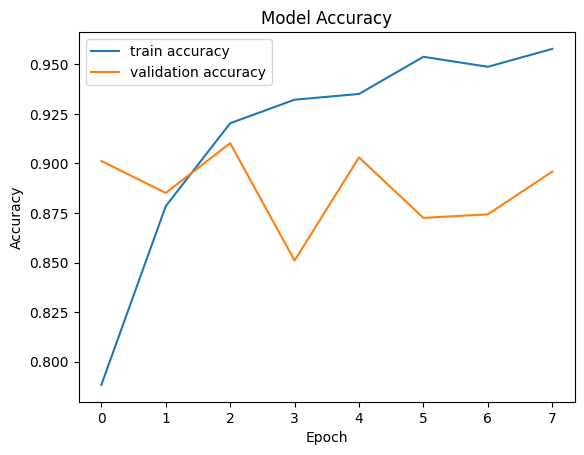

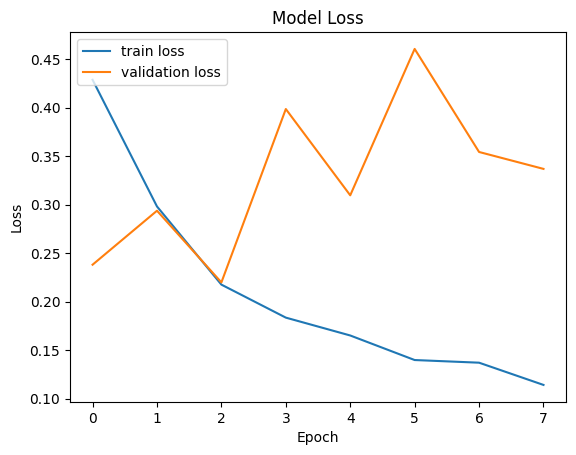

In [88]:
X_train_rgb = np.repeat(X_train_combined, 3, axis=-1)  # Converts (48, 48, 1) to (48, 48, 3)
X_val_rgb = np.repeat(X_val, 3, axis=-1)

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze the initial layers of VGG19 to retain pre-trained features
for layer in base_model.layers[:-8]:  # Adjust number of layers to unfreeze more, if necessary
    layer.trainable = False

# Add custom classification layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x= Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_rgb, Y_train_combined, 
    batch_size=32,
    validation_data=(X_val_rgb, Y_val),
    epochs=30,
    callbacks = [early_stopping]
)

val_preds = model.predict(X_val_rgb)
val_preds = np.round(val_preds)

# Classification report
print(classification_report(Y_val, val_preds))

# F1 Score
f1 = f1_score(Y_val, val_preds, average='macro')
print("F1 Score: ", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_val, val_preds)
print("Confusion Matrix:\n", conf_matrix)

# Plotting training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Pre-trained VGG16

Epoch 1/30


/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 38s 427ms/step - accuracy: 0.6762 - loss: 0.5958 - val_accuracy: 0.9102 - val_loss: 0.2525
Epoch 2/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 36s 412ms/step - accuracy: 0.8562 - loss: 0.3378 - val_accuracy: 0.9048 - val_loss: 0.2149
Epoch 3/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 36s 415ms/step - accuracy: 0.8954 - loss: 0.2692 - val_accuracy: 0.9228 - val_loss: 0.2128
Epoch 4/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 36s 413ms/step - accuracy: 0.8998 - loss: 0.2626 - val_accuracy: 0.9300 - val_loss: 0.1896
Epoch 5/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 35s 397ms/step - accuracy: 0.9192 - loss: 0.2271 - val_accuracy: 0.9156 - val_loss: 0.2748
Epoch 6/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 35s 404ms/step - accuracy: 0.9087 - loss: 0.2571 - val_accuracy: 0.9138 - val_loss: 0.2218
Epoch 7/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 34s 388ms/step - accuracy: 0.9129 - loss: 0.2325 - val_accuracy: 0.9120 - val_loss: 0.2418
Epoch 8/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 34s 390ms/step - accuracy: 0.9115 - loss: 0.2423 - val_accuracy: 0.926

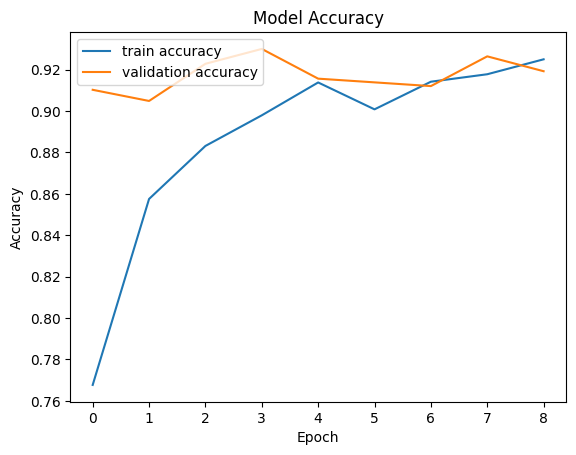

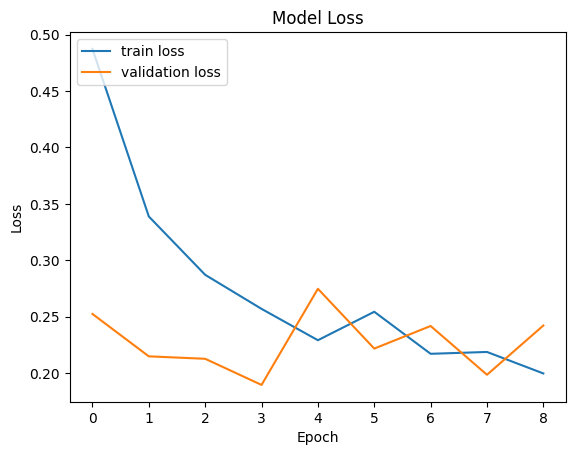

In [89]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

for layer in base_model.layers[:-8]:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    datagen.flow(X_train_rgb, Y_train_combined,batch_size=32), 
    validation_data=(X_val_rgb, Y_val),
    epochs=30,
    callbacks = [early_stopping]
)

val_preds = model.predict(X_val_rgb)
val_preds = np.round(val_preds)

# Classification report
print(classification_report(Y_val, val_preds))

# F1 Score
f1 = f1_score(Y_val, val_preds, average='macro')
print("F1 Score: ", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_val, val_preds)
print("Confusion Matrix:\n", conf_matrix)

# Plotting training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Using the unlabeled data

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_174 (Conv2D)             │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_174               │ (None, 23, 23, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_175 (Conv2D)             │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_175               │ (None, 10, 10, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_176 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_176               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_65 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 363,265 (1.39 MB)

 Trainable params: 363,265 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
 7/87 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4955 - loss: 0.7006

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5071 - loss: 0.6957 - val_accuracy: 0.8061 - val_loss: 0.6296
Epoch 2/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6525 - loss: 0.6642 - val_accuracy: 0.8241 - val_loss: 0.4316
Epoch 3/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7859 - loss: 0.5314 - val_accuracy: 0.8079 - val_loss: 0.4313
Epoch 4/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7820 - loss: 0.5050 - val_accuracy: 0.7774 - val_loss: 0.4932
Epoch 5/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7949 - loss: 0.4753 - val_accuracy: 0.8043 - val_loss: 0.4143
Epoch 6/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7974 - loss: 0.4723 - val_accuracy: 0.8133 - val_loss: 0.4103
Epoch 7/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8046 - loss: 0.4377 - val_accuracy: 0.8456 - val_loss: 0.3986
Epoch 8/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8423 - loss: 0.3977 - val_accuracy: 0.7953 - val_loss: 0.

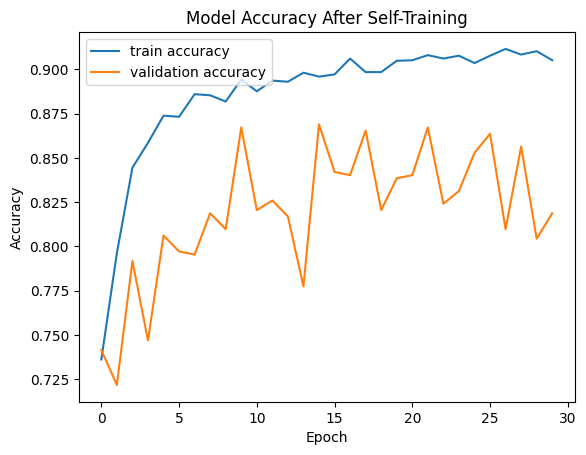

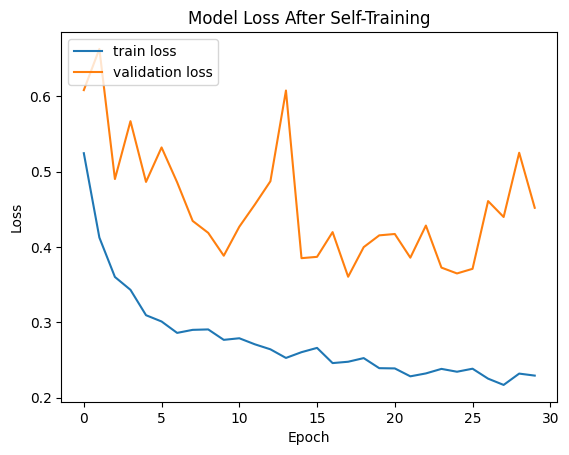

In [136]:
# Normalize the unlabeled data (values between 0 and 1)
X_unlabeled_norm = X_unlabeled / 255.0
X_unlabeled_norm = X_unlabeled_norm.reshape(X_unlabeled_norm.shape[0], 48, 48, 1)

# Train the CNN model on labeled data first (the code you already have)

model = create_model()
model.summary()

batch_size = 32
epochs = 30

# Train the model on the labeled dataset
history = model.fit(
    datagen.flow(X_train_combined, Y_train_combined, batch_size=batch_size),
    validation_data=(X_val, Y_val),
    epochs=epochs
)

# Step 1: Use the trained CNN model to generate pseudo-labels for the unlabeled data
# Get predictions for the unlabeled data
unlabeled_preds = model.predict(X_unlabeled_norm)
print(unlabeled_preds)

# Step 2: Apply a threshold to assign pseudo-labels based on prediction confidence
# For binary classification, pseudo-labels are 0 or 1 depending on confidence
pseudo_labels = np.where(unlabeled_preds > 0.95, 1, np.where(unlabeled_preds < 0.1, 0, -1))
print(pseudo_labels)

# Only keep confident predictions (those with pseudo-labels not equal to -1)
confident_indices = np.where(pseudo_labels != -1)[0]
X_confident = X_unlabeled_norm[confident_indices]
pseudo_labels_confident = pseudo_labels[confident_indices]
# Reshape pseudo_labels_confident if needed
pseudo_labels_confident = pseudo_labels_confident.ravel()


# Step 3: Combine the original labeled data with the pseudo-labeled confident data
X_combined = np.concatenate((X_train, X_confident), axis=0)
y_combined = np.concatenate((Y_train, pseudo_labels_confident), axis=0)

print(X_combined.shape)
print(X_combined)

# Step 4: Retrain the model using the combined labeled + pseudo-labeled data
model = create_model()  # Recreate the model to retrain
history_combined = model.fit(
    datagen.flow(X_combined, y_combined, batch_size=batch_size),
    validation_data=(X_val, Y_val),
    epochs=epochs
)

# Step 5: Evaluate the model
val_preds = model.predict(X_val)
val_preds = np.round(val_preds)

# Classification report
print(classification_report(Y_val, val_preds))

# F1 Score
f1 = f1_score(Y_val, val_preds)
print("F1 Score after self-training: ", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_val, val_preds)
print("Confusion Matrix after self-training:\n", conf_matrix)

# Step 6: Plotting training history for combined data
plt.plot(history_combined.history['accuracy'], label='train accuracy')
plt.plot(history_combined.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy After Self-Training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history_combined.history['loss'], label='train loss')
plt.plot(history_combined.history['val_loss'], label='validation loss')
plt.title('Model Loss After Self-Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


With CV

Training on Fold 1...
Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 7/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5001 - loss: 0.7059 

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4831 - loss: 0.6986 - val_accuracy: 0.4864 - val_loss: 0.6945
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5035 - loss: 0.6934 - val_accuracy: 0.4864 - val_loss: 0.6934
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5151 - loss: 0.6932 - val_accuracy: 0.4846 - val_loss: 0.6935
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5170 - loss: 0.6932 - val_accuracy: 0.4864 - val_loss: 0.6935
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5062 - loss: 0.6930 - val_accuracy: 0.4864 - val_loss: 0.6934
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5118 - loss: 0.6928 - val_accuracy: 0.4882 - val_loss: 0.6925
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5029 - loss: 0.6940 - val_accuracy: 0.4864 - val_loss: 0.6927
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5083 - loss: 0.6921 - val_accuracy: 0.4846 - val_loss: 0.

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 7/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5000 - loss: 0.6964 

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4985 - loss: 0.6969 - val_accuracy: 0.4955 - val_loss: 0.6933
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5123 - loss: 0.6932 - val_accuracy: 0.5045 - val_loss: 0.6932
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5257 - loss: 0.6930 - val_accuracy: 0.5045 - val_loss: 0.6932
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5150 - loss: 0.6935 - val_accuracy: 0.5045 - val_loss: 0.6931
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5154 - loss: 0.6931 - val_accuracy: 0.5045 - val_loss: 0.6931
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5210 - loss: 0.6929 - val_accuracy: 0.5045 - val_loss: 0.6929
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5095 - loss: 0.6932 - val_accuracy: 0.5027 - val_loss: 0.6931
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4891 - loss: 0.6933 - val_accuracy: 0.5045 - val_loss: 0.

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 3/70 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.4462 - loss: 0.6965  

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4998 - loss: 0.6955 - val_accuracy: 0.4874 - val_loss: 0.6934
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4984 - loss: 0.6932 - val_accuracy: 0.5090 - val_loss: 0.6931
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4909 - loss: 0.6934 - val_accuracy: 0.4874 - val_loss: 0.6937
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4973 - loss: 0.6974 - val_accuracy: 0.4874 - val_loss: 0.6936
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5173 - loss: 0.6919 - val_accuracy: 0.4874 - val_loss: 0.6977
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4842 - loss: 0.6920 - val_accuracy: 0.4874 - val_loss: 0.7035
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4878 - loss: 0.6953 - val_accuracy: 0.4874 - val_loss: 0.7063
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5212 - loss: 0.6926 - val_accuracy: 0.4874 - val_loss: 0.

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 7/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5104 - loss: 0.6959 

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4949 - loss: 0.6965 - val_accuracy: 0.5351 - val_loss: 0.6923
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5057 - loss: 0.6935 - val_accuracy: 0.4739 - val_loss: 0.6931
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4965 - loss: 0.6932 - val_accuracy: 0.4703 - val_loss: 0.6932
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5094 - loss: 0.6929 - val_accuracy: 0.5027 - val_loss: 0.6911
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5199 - loss: 0.6973 - val_accuracy: 0.4811 - val_loss: 0.6936
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4945 - loss: 0.6959 - val_accuracy: 0.4703 - val_loss: 0.6940
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5003 - loss: 0.6911 - val_accuracy: 0.4685 - val_loss: 0.6956
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5074 - loss: 0.6929 - val_accuracy: 0.4685 - val_loss: 0.

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 7/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4955 - loss: 0.7032 

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5035 - loss: 0.6962 - val_accuracy: 0.5063 - val_loss: 0.6930
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4986 - loss: 0.6926 - val_accuracy: 0.5063 - val_loss: 0.6930
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5055 - loss: 0.6934 - val_accuracy: 0.5081 - val_loss: 0.6931
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4758 - loss: 0.6935 - val_accuracy: 0.5009 - val_loss: 0.6932
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5049 - loss: 0.6929 - val_accuracy: 0.5045 - val_loss: 0.6928
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4893 - loss: 0.6925 - val_accuracy: 0.5063 - val_loss: 0.6932
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5124 - loss: 0.6928 - val_accuracy: 0.5063 - val_loss: 0.6932
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4939 - loss: 0.6941 - val_accuracy: 0.5063 - val_loss: 0.

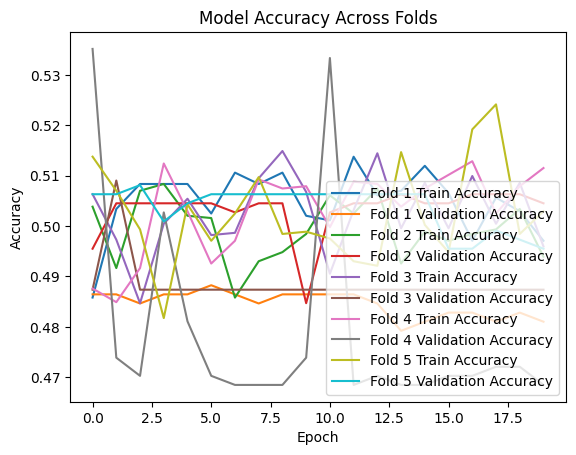

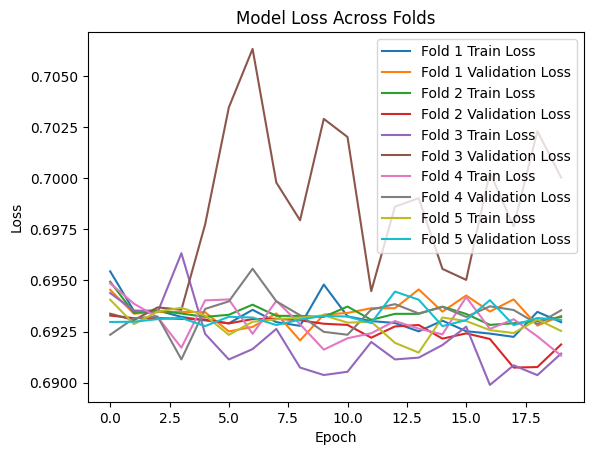

In [94]:
# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Initialize lists to store metrics
f1_scores = []
histories = []

# Perform K-Fold Cross-Validation
fold = 1
for train_index, val_index in kf.split(X_labeled):
    print(f"Training on Fold {fold}...")

    # Ensure indices are within bounds
    train_index = train_index[train_index < len(X_train_combined)]
    val_index = val_index[val_index < len(X_train_combined)]

    # Split the data into training and validation sets
    X_train, X_val = X_train_combined[train_index], X_train_combined[val_index]
    y_train, y_val = Y_train_combined[train_index], Y_train_combined[val_index]
    
    # Flatten the training data for RandomOverSampling
    #X_train_flattened = X_train.reshape((X_train.shape[0], -1))
    
    # Apply RandomOverSampling to balance the training data
    #ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
    #X_train_resampled, y_train_resampled = ros.fit_resample(X_train_flattened, y_train)
    
    # Reshape the resampled data back to image shape
    #X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 48, 48, 1))
    
    # Shuffle the resampled training data
    #X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled, random_state=42)
    
    # Create a new CNN model for each fold
    model = create_model()

    # Train the model with data augmentation
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32), 
        validation_data=(X_val.reshape(X_val.shape[0], 48, 48, 1), y_val),  # Ensure X_val has shape (48, 48, 1)
        epochs=20
    )
    
    # Append the training history for later analysis
    histories.append(history.history)
    
    # Evaluate the model
    val_preds = model.predict(X_val.reshape(X_val.shape[0], 48, 48, 1))
    val_preds = np.round(val_preds)  # Convert probabilities to binary 0 or 1

    # Calculate and store the F1 score
    f1 = f1_score(y_val, val_preds)
    f1_scores.append(f1)

    print(f"F1 Score for Fold {fold}: {f1}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, val_preds)
    print(f"Confusion Matrix for Fold {fold}:\n", conf_matrix)

    # Increment fold number
    fold += 1

# Print average F1 score
print(f"\nAverage F1 Score: {np.mean(f1_scores)}")

# Plot accuracy and loss curves
for i, history in enumerate(histories):
    plt.plot(history['accuracy'], label=f'Fold {i+1} Train Accuracy')
    plt.plot(history['val_accuracy'], label=f'Fold {i+1} Validation Accuracy')
plt.title('Model Accuracy Across Folds')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

for i, history in enumerate(histories):
    plt.plot(history['loss'], label=f'Fold {i+1} Train Loss')
    plt.plot(history['val_loss'], label=f'Fold {i+1} Validation Loss')
plt.title('Model Loss Across Folds')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

Using CV and the new training set (labeled +  labeled through self-learning)

Training on Fold 1...
Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 6/79 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5385 - loss: 0.6795

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7088 - loss: 0.5804 - val_accuracy: 0.7348 - val_loss: 0.4250
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7598 - loss: 0.4445 - val_accuracy: 0.8355 - val_loss: 0.4040
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8247 - loss: 0.3783 - val_accuracy: 0.7300 - val_loss: 0.4406
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8171 - loss: 0.3675 - val_accuracy: 0.8690 - val_loss: 0.3272
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8406 - loss: 0.3303 - val_accuracy: 0.8738 - val_loss: 0.2944
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8537 - loss: 0.3071 - val_accuracy: 0.8435 - val_loss: 0.4249
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8911 - loss: 0.2710 - val_accuracy: 0.8546 - val_loss: 0.3405
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8841 - loss: 0.2786 - val_accuracy: 0.8610 - val_loss: 0.

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 6/79 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5548 - loss: 0.6624

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7148 - loss: 0.5644 - val_accuracy: 0.8227 - val_loss: 0.4348
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8414 - loss: 0.3799 - val_accuracy: 0.8275 - val_loss: 0.4205
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8495 - loss: 0.3515 - val_accuracy: 0.8131 - val_loss: 0.5448
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8660 - loss: 0.3164 - val_accuracy: 0.7955 - val_loss: 0.5787
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8688 - loss: 0.3161 - val_accuracy: 0.7971 - val_loss: 0.3877
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8606 - loss: 0.3225 - val_accuracy: 0.8163 - val_loss: 0.4429
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8828 - loss: 0.2949 - val_accuracy: 0.8403 - val_loss: 0.3401
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8892 - loss: 0.2755 - val_accuracy: 0.8530 - val_loss: 0.

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 8/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6213 - loss: 0.6765 

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7126 - loss: 0.5639 - val_accuracy: 0.7891 - val_loss: 0.6165
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8140 - loss: 0.3961 - val_accuracy: 0.8403 - val_loss: 0.4477
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8495 - loss: 0.3493 - val_accuracy: 0.8754 - val_loss: 0.3256
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8669 - loss: 0.3141 - val_accuracy: 0.8227 - val_loss: 0.4552
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8656 - loss: 0.3100 - val_accuracy: 0.8291 - val_loss: 0.3502
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8716 - loss: 0.2958 - val_accuracy: 0.7971 - val_loss: 0.4518
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8597 - loss: 0.3009 - val_accuracy: 0.8387 - val_loss: 0.3472
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8754 - loss: 0.2861 - val_accuracy: 0.8594 - val_loss: 0.

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 7/79 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5429 - loss: 0.6817 

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7019 - loss: 0.5652 - val_accuracy: 0.8450 - val_loss: 0.3722
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8208 - loss: 0.3955 - val_accuracy: 0.8466 - val_loss: 0.3736
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8500 - loss: 0.3533 - val_accuracy: 0.7780 - val_loss: 0.5696
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8411 - loss: 0.3420 - val_accuracy: 0.8403 - val_loss: 0.3559
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8696 - loss: 0.2937 - val_accuracy: 0.8594 - val_loss: 0.3311
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8733 - loss: 0.3024 - val_accuracy: 0.8850 - val_loss: 0.2954
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8902 - loss: 0.2756 - val_accuracy: 0.8243 - val_loss: 0.3822
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8850 - loss: 0.2724 - val_accuracy: 0.8914 - val_loss: 0.

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 7/79 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4872 - loss: 0.6861 

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6755 - loss: 0.5969 - val_accuracy: 0.8115 - val_loss: 0.4110
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7942 - loss: 0.4167 - val_accuracy: 0.8019 - val_loss: 0.4652
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8436 - loss: 0.3667 - val_accuracy: 0.8163 - val_loss: 0.4085
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8408 - loss: 0.3539 - val_accuracy: 0.7939 - val_loss: 0.5194
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8414 - loss: 0.3454 - val_accuracy: 0.8435 - val_loss: 0.4239
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8775 - loss: 0.2856 - val_accuracy: 0.8498 - val_loss: 0.3555
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8661 - loss: 0.3026 - val_accuracy: 0.8498 - val_loss: 0.3462
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8886 - loss: 0.2890 - val_accuracy: 0.8738 - val_loss: 0.

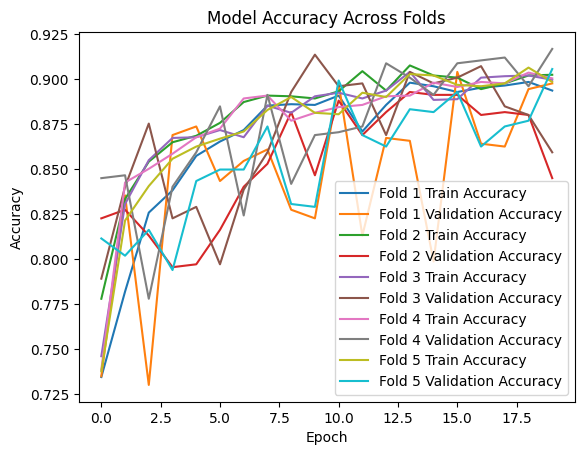

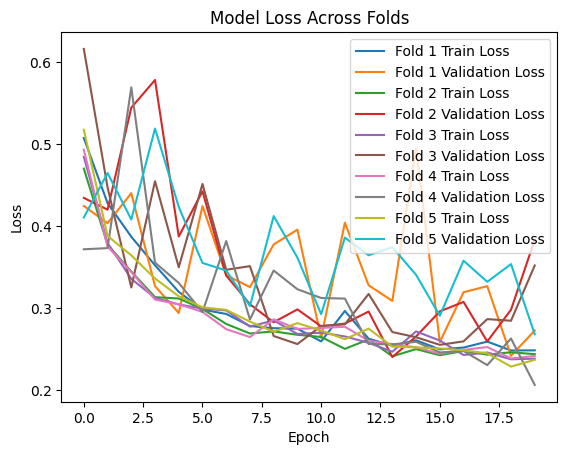

In [95]:
# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Initialize lists to store metrics
f1_scores = []
histories = []

# Perform K-Fold Cross-Validation
fold = 1
for train_index, val_index in kf.split(X_combined):
    print(f"Training on Fold {fold}...")
    
    # Split the data into training and validation sets
    X_train, X_val = X_combined[train_index], X_combined[val_index]
    y_train, y_val = y_combined[train_index], y_combined[val_index]
    
    # Flatten the training data for RandomOverSampling
    #X_train_flattened = X_train.reshape((X_train.shape[0], -1))
    
    # Apply RandomOverSampling to balance the training data
    #ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
    #X_train_resampled, y_train_resampled = ros.fit_resample(X_train_flattened, y_train)
    
    # Reshape the resampled data back to image shape
    #X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 48, 48, 1))
    
    # Shuffle the resampled training data
    #X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled, random_state=42)
    
    # Create a new CNN model for each fold
    model = create_model()

    # Train the model with data augmentation
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32), 
        validation_data=(X_val.reshape(X_val.shape[0], 48, 48, 1), y_val),  # Ensure X_val has shape (48, 48, 1)
        epochs=20
    )
    
    # Append the training history for later analysis
    histories.append(history.history)
    
    # Evaluate the model
    val_preds = model.predict(X_val.reshape(X_val.shape[0], 48, 48, 1))
    val_preds = np.round(val_preds)  # Convert probabilities to binary 0 or 1

    # Calculate and store the F1 score
    f1 = f1_score(y_val, val_preds)
    f1_scores.append(f1)

    print(f"F1 Score for Fold {fold}: {f1}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, val_preds)
    print(f"Confusion Matrix for Fold {fold}:\n", conf_matrix)

    # Increment fold number
    fold += 1

# Print average F1 score
print(f"\nAverage F1 Score: {np.mean(f1_scores)}")

# Plot accuracy and loss curves
for i, history in enumerate(histories):
    plt.plot(history['accuracy'], label=f'Fold {i+1} Train Accuracy')
    plt.plot(history['val_accuracy'], label=f'Fold {i+1} Validation Accuracy')
plt.title('Model Accuracy Across Folds')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

for i, history in enumerate(histories):
    plt.plot(history['loss'], label=f'Fold {i+1} Train Loss')
    plt.plot(history['val_loss'], label=f'Fold {i+1} Validation Loss')
plt.title('Model Loss Across Folds')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

Using a CNN for feature extraction and training the model with a DNN

Training on Fold 1...
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5051 - loss: 0.6996 - val_accuracy: 0.6697 - val_loss: 0.6782
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5167 - loss: 0.6900 - val_accuracy: 0.4847 - val_loss: 0.6895
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5860 - loss: 0.6814 - val_accuracy: 0.7110 - val_loss: 0.6535
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6163 - loss: 0.6636 - val_accuracy: 0.7074 - val_loss: 0.6164
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6536 - loss: 0.6321 - val_accuracy: 0.7397 - val_loss: 0.5723
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6801 - loss: 0.6170 - val_accuracy: 0.6804 - val_loss: 0.6079
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7104 - loss: 0.5927 - val_accuracy: 0.6912 - val_loss: 0.5992
Epoch 8/30
88/88 ━

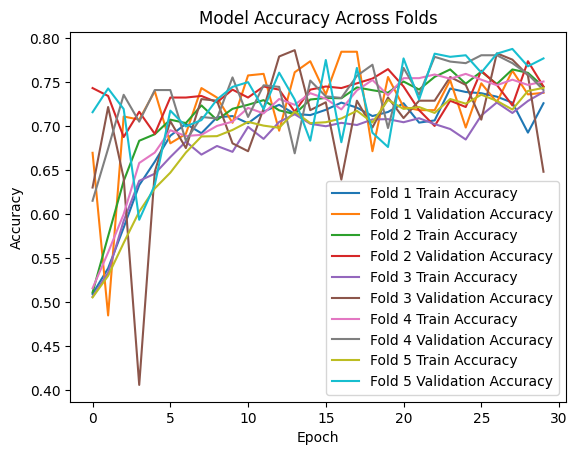

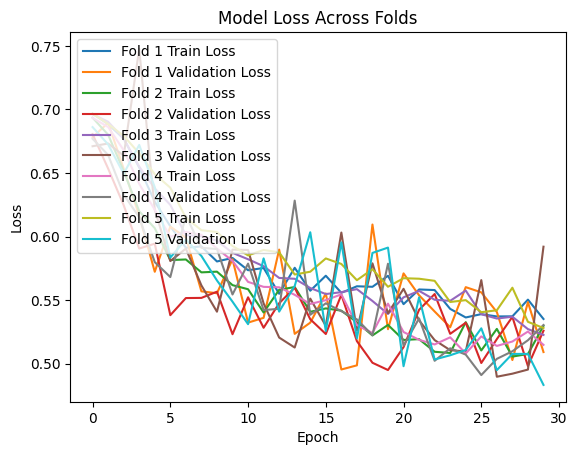

In [96]:
# Using reshaped training data (labeled)
X = X_train_reshaped
y = Y_train_labeled

# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Initialize lists to store metrics
f1_scores = []
histories = []

# Data augmentation using ImageDataGenerator for CNN training
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2]
)

# Build the CNN feature extractor model
def create_cnn_feature_extractor():
    inputs = Input(shape=(48, 48, 1))
    
    # Convolutional Layer 1
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Convolutional Layer 2
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Convolutional Layer 3
    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Flattening
    x = Flatten()(x)

    return Model(inputs, x)

# Build the DNN model
def create_dnn(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(128, activation='relu')(inputs)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification
    
    return Model(inputs, outputs)

# Perform K-Fold Cross-Validation
fold = 1
for train_index, val_index in kf.split(X):
    print(f"Training on Fold {fold}...")
    
    # Split the data into training and validation sets
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Flatten the training data for RandomOverSampling
    X_train_flattened = X_train.reshape((X_train.shape[0], -1))
    
    # Apply RandomOverSampling to balance the training data
    ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train_flattened, y_train)
    
    # Reshape the resampled data back to image shape
    X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 48, 48, 1))
    
    # Shuffle the resampled training data
    X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled, random_state=42)
    
    # Create CNN feature extractor
    cnn_feature_extractor = create_cnn_feature_extractor()
    cnn_features_train = cnn_feature_extractor.predict(X_train_resampled)
    cnn_features_val = cnn_feature_extractor.predict(X_val.reshape(X_val.shape[0], 48, 48, 1))
    
    # Ensure that the features are flattened before feeding to DNN
    cnn_features_train = cnn_features_train.reshape((cnn_features_train.shape[0], -1))  # Flatten the features
    cnn_features_val = cnn_features_val.reshape((cnn_features_val.shape[0], -1))  # Flatten the features
    
    # Create the DNN model
    dnn_model = create_dnn(cnn_features_train.shape[1:])
    
    # Compile the DNN model
    dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the DNN model without data augmentation
    history = dnn_model.fit(
        cnn_features_train, y_train_resampled,
        validation_data=(cnn_features_val, y_val),
        epochs=30,
        batch_size=32
    )
    
    # Append the training history for later analysis
    histories.append(history.history)
    
    # Evaluate the DNN model
    val_preds = dnn_model.predict(cnn_features_val)
    val_preds = np.round(val_preds)  # Convert probabilities to binary 0 or 1

    # Calculate and store the F1 score
    f1 = f1_score(y_val, val_preds)
    f1_scores.append(f1)

    print(f"F1 Score for Fold {fold}: {f1}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, val_preds)
    print(f"Confusion Matrix for Fold {fold}:\n", conf_matrix)

    # Increment fold number
    fold += 1

# Print average F1 score
print(f"\nAverage F1 Score: {np.mean(f1_scores)}")

# Plot accuracy and loss curves
for i, history in enumerate(histories):
    plt.plot(history['accuracy'], label=f'Fold {i+1} Train Accuracy')
    plt.plot(history['val_accuracy'], label=f'Fold {i+1} Validation Accuracy')
plt.title('Model Accuracy Across Folds')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

for i, history in enumerate(histories):
    plt.plot(history['loss'], label=f'Fold {i+1} Train Loss')
    plt.plot(history['val_loss'], label=f'Fold {i+1} Validation Loss')
plt.title('Model Loss Across Folds')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


Training on Fold 1...
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6530 - loss: 0.6703 - val_accuracy: 0.7110 - val_loss: 0.5879
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6836 - loss: 0.5905 - val_accuracy: 0.7110 - val_loss: 0.5157
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7107 - loss: 0.5349 - val_accuracy: 0.7110 - val_loss: 0.5124
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7012 - loss: 0.5304 - val_accuracy: 0.7110 - val_loss: 0.5032
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6884 - loss: 0.5234 - val_accuracy: 0.7110 - val_loss: 0.4978
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7046 - loss: 0.5161 - val_accuracy: 0.7110 - val_loss: 0.4984
Epoch 7/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6928 - loss: 0.5126 - val_accuracy: 0.7110 - val_loss: 0.4900
Epoch 8/30
71/71 ━

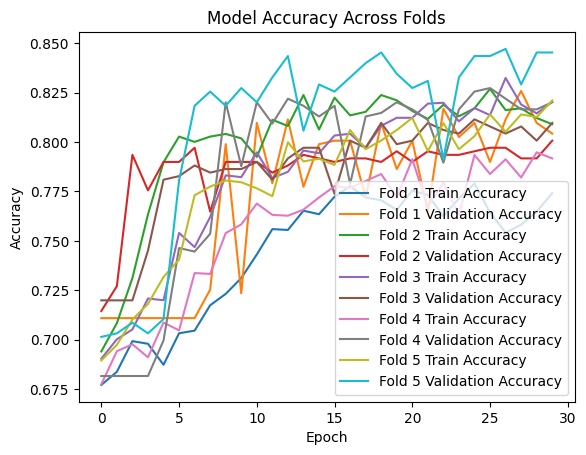

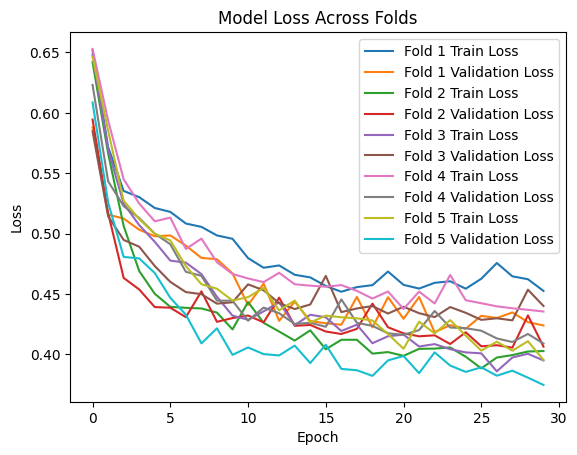

In [97]:
# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Initialize lists to store metrics
f1_scores = []
histories = []

# Build the CNN feature extractor model
def create_cnn_feature_extractor():
    inputs = Input(shape=(48, 48, 1))
    
    # Convolutional Layer 1
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Convolutional Layer 2
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Convolutional Layer 3
    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Flattening
    x = Flatten()(x)

    return Model(inputs, x)

# Build the DNN model
def create_dnn(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(128, activation='relu')(inputs)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification
    
    return Model(inputs, outputs)

# Perform K-Fold Cross-Validation
fold = 1
for train_index, val_index in kf.split(X):
    print(f"Training on Fold {fold}...")
    
    # Split the data into training and validation sets
    X_train, X_val = X_combined[train_index], X_combined[val_index]
    y_train, y_val = y_combined[train_index], y_combined[val_index]
    
    # Flatten the training data for RandomOverSampling
    X_train_flattened = X_train.reshape((X_train.shape[0], -1))
    
    # Apply RandomOverSampling to balance the training data
    ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train_flattened, y_train)
    
    # Reshape the resampled data back to image shape
    X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 48, 48, 1))
    
    # Shuffle the resampled training data
    X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled, random_state=42)
    
    # Create CNN feature extractor
    cnn_feature_extractor = create_cnn_feature_extractor()
    cnn_features_train = cnn_feature_extractor.predict(X_train_resampled)
    cnn_features_val = cnn_feature_extractor.predict(X_val.reshape(X_val.shape[0], 48, 48, 1))
    
    # Ensure that the features are flattened before feeding to DNN
    cnn_features_train = cnn_features_train.reshape((cnn_features_train.shape[0], -1))  # Flatten the features
    cnn_features_val = cnn_features_val.reshape((cnn_features_val.shape[0], -1))  # Flatten the features
    
    # Create the DNN model
    dnn_model = create_dnn(cnn_features_train.shape[1:])
    
    # Compile the DNN model
    dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the DNN model without data augmentation
    history = dnn_model.fit(
        cnn_features_train, y_train_resampled,
        validation_data=(cnn_features_val, y_val),
        epochs=30,
        batch_size=32
    )
    
    # Append the training history for later analysis
    histories.append(history.history)
    
    # Evaluate the DNN model
    val_preds = dnn_model.predict(cnn_features_val)
    val_preds = np.round(val_preds)  # Convert probabilities to binary 0 or 1

    # Calculate and store the F1 score
    f1 = f1_score(y_val, val_preds)
    f1_scores.append(f1)

    print(f"F1 Score for Fold {fold}: {f1}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, val_preds)
    print(f"Confusion Matrix for Fold {fold}:\n", conf_matrix)

    # Increment fold number
    fold += 1

# Print average F1 score
print(f"\nAverage F1 Score: {np.mean(f1_scores)}")

# Plot accuracy and loss curves
for i, history in enumerate(histories):
    plt.plot(history['accuracy'], label=f'Fold {i+1} Train Accuracy')
    plt.plot(history['val_accuracy'], label=f'Fold {i+1} Validation Accuracy')
plt.title('Model Accuracy Across Folds')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

for i, history in enumerate(histories):
    plt.plot(history['loss'], label=f'Fold {i+1} Train Loss')
    plt.plot(history['val_loss'], label=f'Fold {i+1} Validation Loss')
plt.title('Model Loss Across Folds')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()
